**Tracking Unique Insect Species in the City of Melbourne**

Authored by: Rohang Shah
Duration: 90 mins
Level: Intermediate
Pre-requisite Skills: Python, Data Analysis, Geospatial Analysis


In the context of urban biodiversity, tracking the presence and distribution of unique insect species can significantly aid in conservation efforts. This use case focuses on identifying and monitoring areas within the City of Melbourne where certain insect species are found uniquely, compared to other areas. By analyzing the insect records collected from the Little Things that Run the City Project and subsequent Melbourne BioBlitz events, the City of Melbourne can pinpoint locations where rare or unique insect species are present. This enables the city to focus conservation efforts on these critical areas to protect and preserve these species and their habitats.

**What this Use Case Will Teach You**
At the end of this use case, you will:

*   Learn how to access and manipulate City of Melbourne Open Data.
*   Develop skills in geospatial data analysis.
*   Gain experience in identifying patterns and anomalies in biodiversity data.
*   Understand how to use data analysis to inform conservation strategies.


**Introduction or Background**
Urbanization poses a significant threat to biodiversity. The City of Melbourne, through projects like the Little Things that Run the City and Melbourne BioBlitz events, has collected valuable data on insect species within the city. This data can be leveraged to identify and protect unique insect species and their habitats. By focusing conservation efforts on areas where these species are found, the City of Melbourne can enhance its biodiversity and ensure the sustainability of its ecosystems.


**User Story**
Title: Protecting Melbourne's Unique Insect Species
As a conservation biologist working with the City of Melbourne, I want to identify and monitor areas within the city where certain insect species are uniquely found so that I can focus conservation efforts on these critical habitats to protect and preserve these species and their ecosystems.

**Scenario**
The City of Melbourne has been collecting insect data through the "Little Things that Run the City" project and the Melbourne BioBlitz events. This data includes observations of various insect species across different locations in the city. As a conservation biologist, my goal is to analyse this data to pinpoint areas with unique insect species that are not found elsewhere. By identifying these critical habitats, the city can prioritize conservation efforts, allocate resources effectively, and develop strategies to protect these unique species from urban development and other threats.

**Datasets Used**

This use case combines the following datasets from the [City of Melbourne Open Data Portal](https://data.melbourne.vic.gov.au):

- **BioBlitz 2014 Insect Observations**  
  [Link](https://data.melbourne.vic.gov.au/Environment/BioBlitz-2014-Insect-Observations/hz6b-7n4f)

- **BioBlitz 2016 Insect Observations**  
  [Link](https://data.melbourne.vic.gov.au/Environment/BioBlitz-2016-Insect-Observations/qf78-9v9a)

- **Little Things That Run the City – Insect Survey**  
  [Link](https://data.melbourne.vic.gov.au/Environment/Little-Things-That-Run-The-City-Insect-Survey/9p3w-6cvg)







# Step 1: Importing Libraries

We start by importing the necessary Python libraries required for data manipulation, geospatial analysis, clustering, and visualisation. These include libraries such as `pandas`, `geopandas`, `folium`, and `pygbif`, which allow us to work with both local and API datasets for insect species. ### About GBIF API and pygbif

The [GBIF (Global Biodiversity Information Facility)](https://www.gbif.org/) is an international open data platform that provides biodiversity occurrence data across the globe.

We use the `pygbif` library to query insect species records from the GBIF API for all of Australia. This allows us to compare national-level species sightings with local City of Melbourne data, and identify species that are uniquely observed within Melbourne.



In [2]:
import pandas as pd
import requests
from io import StringIO
import geopandas as gpd
from sklearn.cluster import DBSCAN
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from IPython.display import IFrame, display
from tabulate import tabulate

!pip install pygbif

from pygbif import occurrences
import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.0 MB/s eta 0:00:00



# Step 2: Loading and Combining City of Melbourne Datasets

This step loads three datasets from the City of Melbourne Open Data platform using their API. These datasets include observations from BioBlitz 2014, BioBlitz 2016, and the 'Little Things That Run the City' project. All datasets are combined to create a single biodiversity dataset.


In [3]:
# Function to collect and return a single dataset
def collect_data(dataset_id, apikey=""):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    suffix = 'exports/csv?delimiter=%3B&list_separator=%2C&quote_all=false&with_bom=true'

    url = f'{base_url}{dataset_id}/{suffix}'
    params = {
        'select': '*',
        'limit': -1,
        'lang': 'en',
        'timezone': 'UTC',
        'api_key': apikey
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    df = pd.read_csv(StringIO(response.text), delimiter=';')
    return df

# List of all dataset IDs
DATASET_IDS = [
    'insect-records-in-the-city-of-melbourne-from-little-things-that-run-the-city',
    'wildlife-sightings-bioblitz-2014',
    'bioblitz-2016'
]

# Optional: API key
API_KEY = ""

# Collect and combine all datasets
all_dataframes = []

for dataset_id in DATASET_IDS:
    df = collect_data(dataset_id, apikey=API_KEY)
    df['source_dataset'] = dataset_id  # Add a column to track which dataset the data came from
    all_dataframes.append(df)

# Combine into a single DataFrame
df_all = pd.concat(all_dataframes, ignore_index=True)

# Show info about combined dataset
print("Combined DataFrame Info:")
print(tabulate(df_all.info(), headers='keys', tablefmt='psql'))

print("\nDataFrame Description:")
print(tabulate(df_all.describe(include='all'), headers='keys', tablefmt='psql'))

print("\nFirst 5 Rows of Combined DataFrame:")
print(tabulate(df_all.head(), headers='keys', tablefmt='psql'))


Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   taxa                  3318 non-null   object 
 1   kingdom               3318 non-null   object 
 2   phylum                3287 non-null   object 
 3   class                 3279 non-null   object 
 4   order                 3141 non-null   object 
 5   family                3096 non-null   object 
 6   genus                 2208 non-null   object 
 7   species               1769 non-null   object 
 8   identification_notes  1669 non-null   object 
 9   location              1963 non-null   object 
 10  sighting_date         1963 non-null   object 
 11  source_dataset        3321 non-null   object 
 12  common_name           1457 non-null   object 
 13  data_resource_name    2026 non-null   object 
 14  latitude              2024 non-null   float64
 

Printing column names of the dataset.

Displays all column headers to help understand dataset structure.

In [4]:

print("Column Names:")
print(df.columns)

# Fetch the first 300 records of insect sightings in Australia
results = occurrences.search(taxonKey=216, country='AU', limit=300)

# Convert the 'results' section into a DataFrame
records = pd.DataFrame(results['results'])

# Preview columns
records[['scientificName', 'decimalLatitude', 'decimalLongitude', 'eventDate']].head()



Column Names:
Index(['taxa', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus',
       'species', 'common_name', 'identification_notes', 'data_resource_name',
       'sighting_date', 'latitude', 'longitude', 'location', 'geopoint',
       'source_dataset'],
      dtype='object')


,scientificName,decimalLatitude,decimalLongitude,eventDate
0,"Pheidole Westwood, 1839",-35.338516,149.074306,2025-01-10T20:33
1,"Stigmatium Gray, 1831",-35.388089,149.029653,2025-01-14T11:56:56
2,Illeis galbula,-38.200000,146.000000,2025-01-22T10:00Z
3,"Castiarina watkinsi (Barker, 1988)",-35.742095,149.274893,2025-01-08T05:51
4,"Caedicia simplex (Walker, 1869)",-35.247364,149.138362,2025-01-23T22:20


🧭 Extracting latitude and longitude from 'location' column.
A function tries to extract latitude and longitude values from the location string field.

In [5]:
# First, make a fresh copy from the combined dataset
df = df_all.copy()

# Use 'geopoint' to extract lat/lon if available
def extract_from_geopoint(geo):
    try:
        lat, lon = map(float, geo.split(','))
        return pd.Series([lat, lon])
    except:
        return pd.Series([None, None])

df[['latitude', 'longitude']] = df['geopoint'].apply(extract_from_geopoint)

# Drop rows with missing coordinates
df_cleaned = df.dropna(subset=['latitude', 'longitude'])

# Drop rows with missing species
df_cleaned = df_cleaned[df_cleaned['species'].notnull()]

# Drop duplicates
df_cleaned = df_cleaned.drop_duplicates()

# Display cleaned dataset info
print("\n✅ Cleaned DataFrame Info:")
print(df_cleaned.info())

# Confirm non-empty species
print("\nUnique species found:", df_cleaned['species'].nunique())

# Keep only relevant columns and rename them to match your main dataset
gbif_df = records[['scientificName', 'decimalLatitude', 'decimalLongitude', 'eventDate']].copy()
gbif_df = gbif_df.rename(columns={
    'scientificName': 'species',
    'decimalLatitude': 'latitude',
    'decimalLongitude': 'longitude',
    'eventDate': 'sighting_date'
})

# Drop missing values
gbif_df = gbif_df.dropna(subset=['species', 'latitude', 'longitude'])

# Format date
gbif_df['sighting_date'] = pd.to_datetime(gbif_df['sighting_date'], errors='coerce')

# Add a source column
gbif_df['source'] = 'GBIF_API'

# Preview
gbif_df.head()




✅ Cleaned DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 846 entries, 1975 to 3317
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   taxa                  846 non-null    object 
 1   kingdom               846 non-null    object 
 2   phylum                846 non-null    object 
 3   class                 846 non-null    object 
 4   order                 846 non-null    object 
 5   family                846 non-null    object 
 6   genus                 846 non-null    object 
 7   species               846 non-null    object 
 8   identification_notes  101 non-null    object 
 9   location              0 non-null      object 
 10  sighting_date         845 non-null    object 
 11  source_dataset        846 non-null    object 
 12  common_name           802 non-null    object 
 13  data_resource_name    846 non-null    object 
 14  latitude              846 non-null    float64
 1

,species,latitude,longitude,sighting_date,source
0,"Pheidole Westwood, 1839",-35.338516,149.074306,2025-01-10 20:33:00,GBIF_API
1,"Stigmatium Gray, 1831",-35.388089,149.029653,NaT,GBIF_API
2,Illeis galbula,-38.200000,146.000000,NaT,GBIF_API
3,"Castiarina watkinsi (Barker, 1988)",-35.742095,149.274893,2025-01-08 05:51:00,GBIF_API
4,"Caedicia simplex (Walker, 1869)",-35.247364,149.138362,2025-01-23 22:20:00,GBIF_API



# Data Analysis – Identifying Unique Species

We identify all unique insect species recorded in the cleaned dataset. This helps us understand the biodiversity captured and sets the stage for identifying species that may be unique to Melbourne or specific locations within the city.


In [6]:
# Identify unique insect species
unique_species = df_cleaned['species'].unique()

# Display number of unique species
num_unique_species = len(unique_species)
print(f"Number of unique insect species: {num_unique_species}")

# Display unique species names
print("Unique insect species names:")
print(unique_species)


Number of unique insect species: 370
Unique insect species names:
['ficifolia' 'leucoxylon' 'mearnsii' 'ewingii' 'spallanzanii' 'laticeps'
 'lucidoculatus' 'triangularis' 'polyphemus' 'minitabunda' 'excavata'
 'tibicen' 'molucca' 'jubata' 'melanophrys' 'porphyrio' 'castanea'
 'merula' 'tristis' 'lophotes' 'bergii' 'elegans' 'tenebrosa' 'modesta'
 'eximius' 'atra' 'montanus' 'carbo' 'torquatus' 'albiscapa' 'harmonica'
 'australis' 'poliocephalus' 'domesticus' 'novaeguineae' 'melanoleucos'
 'mellori' 'chrysoptera' 'tenuirostris' 'cyanoleuca' 'miles' 'caledonicus'
 'novaehollandiae' 'melanocephala' 'superciliosa' 'peregrinus' 'graculina'
 'haematodus' 'carunculata' 'haematonotus' 'livia' 'regia' 'chinensis'
 'punctatus' 'spinicollis' 'galerita' 'cyaneus' 'neoxena' 'penicillata'
 'leucophrys' 'maenas' 'laevis' 'serenus' 'scaber' 'deflexifrons' 'ovatus'
 'amurensis' 'holbrooki' 'bifrenatus' 'semifasciata' 'anolius'
 'tasmanianus' 'glaber' 'commune' 'luteola' 'mellifera' 'papuensis'
 'anactu

***Concatenate the Datasets***

In [7]:
# Merge the GBIF records into your main dataset
combined_df = pd.concat([df_cleaned, gbif_df], ignore_index=True)
print("Combined dataset shape:", combined_df.shape)


Combined dataset shape: (1146, 18)


***Comparing Species: Melbourne vs National***
To See which species are found only in Melbourne, not in the rest of Australia

Using value_counts() or groupby() to analyse distribution


In [8]:
melb_species = df_cleaned['species'].unique()
gbif_species = gbif_df['species'].unique()

unique_to_melb = set(melb_species) - set(gbif_species)
print("Species unique to Melbourne:", unique_to_melb)


Species unique to Melbourne: {'paucimaculatus', 'gracilis', 'stolonifera', 'lateralis', 'vulpecula', 'livia', 'neoxena', 'coccineus', 'spicata', 'frontalis', 'itea', 'discalis', 'semifasciata', 'microphylla', 'pallidus', 'discolor', 'erythroneurum', 'sparshalli', 'pusilla', 'hopei', 'parabolica', 'taeniolatus', 'melanochra', 'communis', 'villida', 'superciliosa', 'caledonicus', 'himantopus', 'erycinaea', 'araucana', 'excavata', 'harmonica', 'caldwellii', 'vitellina', 'haematodus', 'ombrophanes', 'miles', 'glabra', 'jonesii', 'galerita', 'crispatum', 'distichophylla', 'humeralis', 'eximius', 'petioralis', 'nobilis', 'luteola', 'melanocephala', 'zonalis', 'implexicoma', 'otis', 'insignis', 'gomphocephala', 'papulentus', 'polycarpa', 'integrifolia', 'micalis', 'basaltica', 'bifrenatus', 'johnsonii', 'partita', 'anolius', 'personatus', 'gouldii', 'strigoides', 'tibicen', 'relatalis', 'deliciosella', 'concinna', 'acroxantha', 'rapae', 'cyanoleuca', 'albiscapa', 'triangularis', 'australasica


# Step: Spatial Distribution

We convert the cleaned data into a spatial GeoDataFrame so we can conduct geospatial analysis. This transformation allows us to generate maps and cluster plots to locate biodiversity hotspots or gaps.


In [9]:
import geopandas as gpd

# Ensure 'latitude' and 'longitude' exist and are numeric
df_cleaned = df_cleaned.dropna(subset=['latitude', 'longitude'])

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_cleaned,
    geometry=gpd.points_from_xy(df_cleaned['longitude'], df_cleaned['latitude']),
    crs="EPSG:4326"  # WGS84 coordinate reference system
)

# Preview GeoDataFrame
print(gdf.head())


           taxa   kingdom      phylum          class      order      family  \
1975      Plant   PLANTAE  CHAROPHYTA  EQUISETOPSIDA   MYRTALES   MYRTACEAE   
1976      Plant   PLANTAE  CHAROPHYTA  EQUISETOPSIDA   MYRTALES   MYRTACEAE   
1981      Plant   PLANTAE  CHAROPHYTA  EQUISETOPSIDA    FABALES    FABACEAE   
1983  Amphibian  ANIMALIA    CHORDATA       AMPHIBIA      ANURA     HYLIDAE   
1984    Annelid  ANIMALIA    ANNELIDA     POLYCHAETA  SABELLIDA  SABELLIDAE   

           genus       species identification_notes location sighting_date  \
1975    Corymbia     ficifolia                  NaN      NaN    2016-04-15   
1976  Eucalyptus    leucoxylon                  NaN      NaN    2016-04-15   
1981      Acacia      mearnsii                  NaN      NaN    2016-04-15   
1983     Litoria       ewingii                  NaN      NaN    2016-03-05   
1984     Sabella  spallanzanii                  NaN      NaN    2016-03-02   

     source_dataset                                commo


# Step: Map Visualisation Using Folium

In this step, we plot the insect species on an interactive map using `folium`. Each sighting is marked with a circle, and species names are shown on hover. This helps visualise the geographic spread of insect sightings across Melbourne.
We group insect sightings by location to calculate species richness. This heatmap helps visualise biodiversity hotspots within Melbourne and guides targeted conservation planning.



In [10]:
import folium

# Initialize a map centered around Melbourne
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)

# Add insect observation markers to the map
for _, row in gdf.iterrows():
    popup_text = f"Species: {row['species']}" if pd.notnull(row['species']) else "Species: Unknown"
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        popup=popup_text,
        color='green',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Save and optionally display the map
m



# Step: Time Series Analysis

We analyse the temporal trends in insect sightings using monthly frequency plots. This highlights seasonal patterns, such as increased sightings during spring or summer months, and helps monitor long-term biodiversity trends.
We group insect sightings by location to calculate species richness. This heatmap helps visualise biodiversity hotspots within Melbourne and guides targeted conservation planning.



<ipython-input-11-6120587bf4f8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['month'] = df_time['sighting_date'].dt.to_period('M')


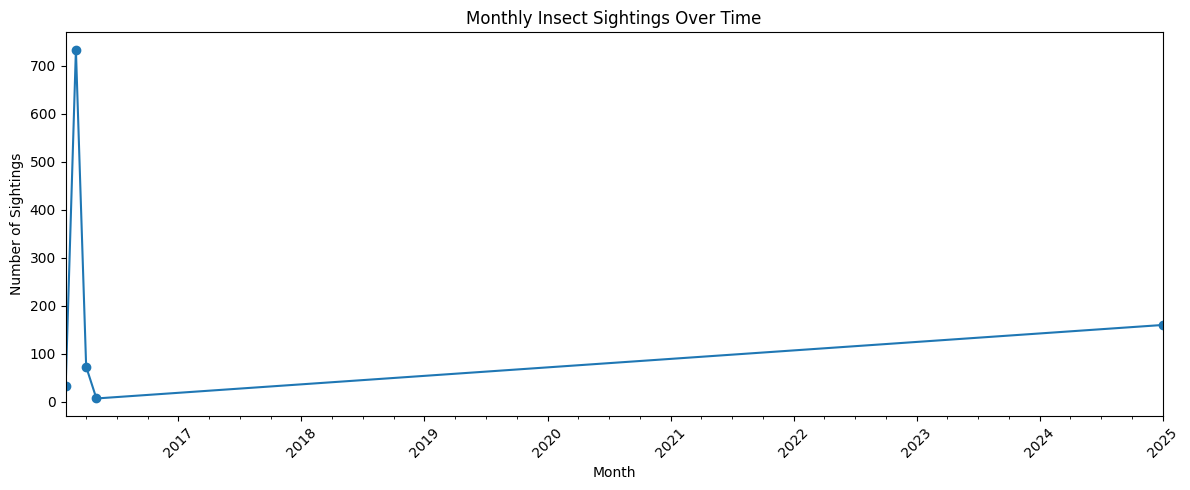

In [11]:
import matplotlib.pyplot as plt

# Ensure sighting_date is in datetime format
combined_df['sighting_date'] = pd.to_datetime(combined_df['sighting_date'], errors='coerce')

# Drop rows without valid dates
df_time = combined_df.dropna(subset=['sighting_date'])

# Create 'month' column
df_time['month'] = df_time['sighting_date'].dt.to_period('M')

# Count number of sightings per month
monthly_counts = df_time.groupby('month').size()

# Plot
monthly_counts.plot(figsize=(12, 5), marker='o', title="Monthly Insect Sightings Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Sightings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Step: Finding Species Unique to One Location

This step identifies species that were only ever recorded at a single geographic location. These species may be more vulnerable to environmental changes and are key candidates for local conservation efforts.


In [12]:
# Round coordinates to create a consistent location key
combined_df['location_key'] = combined_df[['latitude', 'longitude']].round(4).astype(str).agg('_'.join, axis=1)

# Count how many unique locations each species was seen in
species_location_counts = combined_df.groupby('species')['location_key'].nunique()

# Filter species that were seen in only one location
unique_species = species_location_counts[species_location_counts == 1].index

# Extract those records
unique_species_df = combined_df[combined_df['species'].isin(unique_species)]

print(f"🔍 Total species found in only one location: {len(unique_species)}")

# Preview
unique_species_df[['species', 'latitude', 'longitude']].drop_duplicates().head()


🔍 Total species found in only one location: 369


,species,latitude,longitude
0,ficifolia,-37.7886,144.9667
5,laticeps,-37.8419,144.9143
7,triangularis,-37.8303,144.8999
11,excavata,-37.8175,144.9867
32,bergii,-37.8310,144.9100



# Step: Biodiversity Heatmap

We generate a heatmap showing the richness (number of different species) per location. Higher richness areas may indicate local biodiversity hotspots, guiding future preservation or restoration efforts. We group insect sightings by location to calculate species richness. This heatmap helps visualise biodiversity hotspots within Melbourne and guides targeted conservation planning.



In [13]:
from folium.plugins import HeatMap

# Round lat/lon to group nearby points
combined_df['lat_lon'] = combined_df[['latitude', 'longitude']].round(4).astype(str).agg('_'.join, axis=1)

# Count unique species per lat-lon group
biodiversity = combined_df.groupby('lat_lon')['species'].nunique().reset_index()
biodiversity[['latitude', 'longitude']] = biodiversity['lat_lon'].str.split('_', expand=True).astype(float)
biodiversity.rename(columns={'species': 'species_richness'}, inplace=True)

# Create heatmap
heat_data = [[row['latitude'], row['longitude'], row['species_richness']] for _, row in biodiversity.iterrows()]
heatmap = folium.Map(location=[-25, 134], zoom_start=4)
HeatMap(heat_data, radius=10).add_to(heatmap)
heatmap


Let's build two separate biodiversity heatmaps — one for:

🟥 Melbourne datasets only (BioBlitz + Little Things)
🟦 GBIF dataset (national insect sightings from API)

This allows us to compare species richness (diversity) across local vs national data visually.

In [14]:
from folium.plugins import HeatMap
import folium

def show_biodiversity_heatmap(df, center=[-25, 134], zoom=4, title="Biodiversity Heatmap"):
    df['lat_lon'] = df[['latitude', 'longitude']].round(4).astype(str).agg('_'.join, axis=1)
    biodiversity = df.groupby('lat_lon')['species'].nunique().reset_index()
    biodiversity[['latitude', 'longitude']] = biodiversity['lat_lon'].str.split('_', expand=True).astype(float)
    biodiversity.rename(columns={'species': 'species_richness'}, inplace=True)

    heat_data = [[row['latitude'], row['longitude'], row['species_richness']] for _, row in biodiversity.iterrows()]
    m = folium.Map(location=center, zoom_start=zoom)
    HeatMap(heat_data, radius=10, blur=15).add_to(m)
    return m

# 🟥 Melbourne Heatmap
melb_map = show_biodiversity_heatmap(
    combined_df,
    center=[-37.8136, 144.9631],
    zoom=12,
    title="Melbourne Biodiversity"
)

melb_map  # <-- This renders the map inline in Colab





# Step: Taxonomic Summary

This section analyses the dataset by taxonomic groupings—family, genus, and order—to understand which insect groups dominate and how ecological diversity is distributed.


🔝 Top 10 Families:
 family
MELIPHAGIDAE    40
ANATIDAE        36
RALLIDAE        26
COLUMBIDAE      24
ARTAMIDAE       23
POACEAE         22
MYRTACEAE       16
PSITTACIDAE     15
OECOPHORIDAE    14
FABACEAE        14
Name: count, dtype: int64


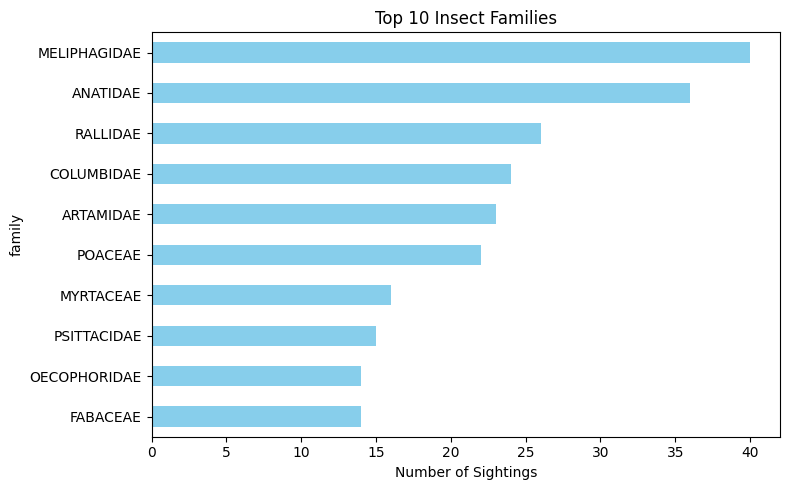

🔝 Top 10 Genus:
 genus
Anas             28
Cracticus        17
Anthochaera      16
Grallina         12
Trichoglossus    11
Rhipidura        10
Corvus           10
Gallinula        10
Pieris           10
Columba           9
Name: count, dtype: int64


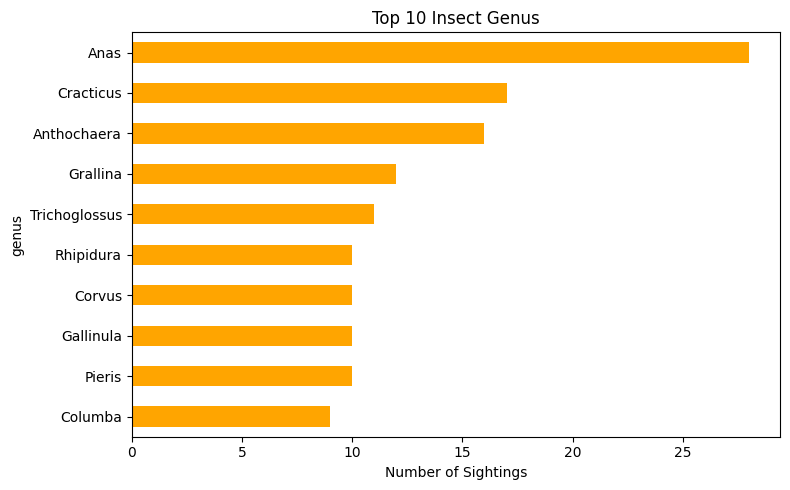

🔝 Top 10 Orders:
 order
PASSERIFORMES     147
LEPIDOPTERA       107
POALES             38
ANSERIFORMES       36
PSITTACIFORMES     31
GRUIFORMES         26
COLEOPTERA         24
COLUMBIFORMES      24
CICONIIFORMES      22
HEMIPTERA          21
Name: count, dtype: int64


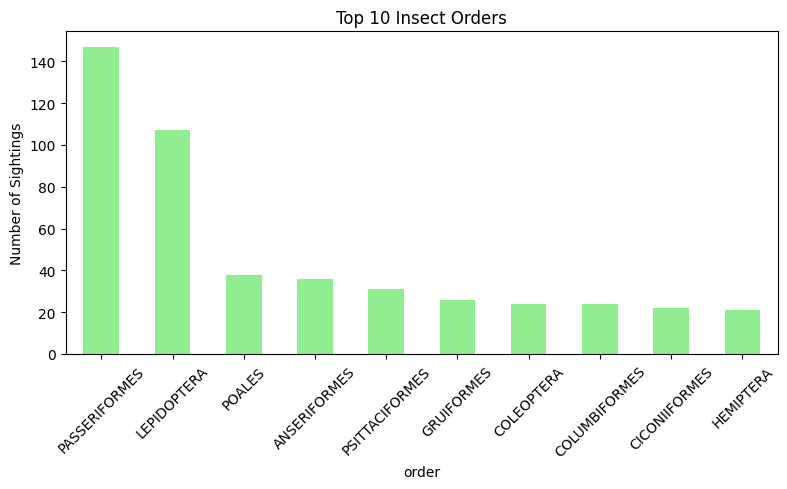

In [15]:
import matplotlib.pyplot as plt

# Top 10 Families
top_families = combined_df['family'].value_counts().head(10)
print("🔝 Top 10 Families:\n", top_families)

# Plot
top_families.plot(kind='barh', title='Top 10 Insect Families', figsize=(8, 5), color='skyblue')
plt.xlabel("Number of Sightings")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



# Top 10 Genus
top_genus = combined_df['genus'].value_counts().head(10)
print("🔝 Top 10 Genus:\n", top_genus)


# Plot
top_genus.plot(kind='barh', title='Top 10 Insect Genus', figsize=(8, 5), color='orange')
plt.xlabel("Number of Sightings")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Top 10 Orders
top_orders = combined_df['order'].value_counts().head(10)
print("🔝 Top 10 Orders:\n", top_orders)

# Plot
top_orders.plot(kind='bar', title='Top 10 Insect Orders', figsize=(8, 5), color='lightgreen')
plt.ylabel("Number of Sightings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Step: Seasonal Trends

This analysis groups sightings by season to understand insect activity across different parts of the year. In the Southern Hemisphere, these trends help tailor conservation strategies based on seasonality.


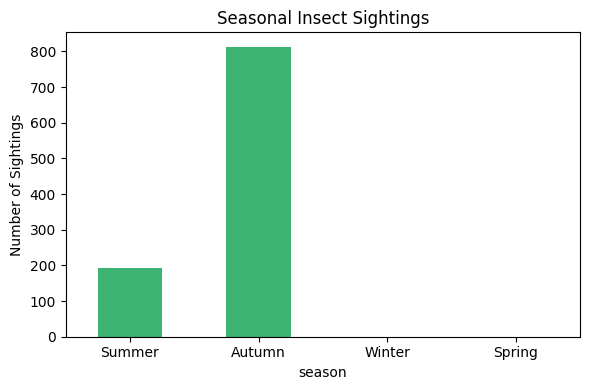

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure sighting_date is datetime
combined_df['sighting_date'] = pd.to_datetime(combined_df['sighting_date'], errors='coerce')

# Function to assign seasons based on month (Southern Hemisphere)
def get_season(date):
    if pd.isnull(date):
        return None
    month = date.month
    if month in [12, 1, 2]:
        return "Summer"
    elif month in [3, 4, 5]:
        return "Autumn"
    elif month in [6, 7, 8]:
        return "Winter"
    else:
        return "Spring"

# Apply function to create a 'season' column
combined_df['season'] = combined_df['sighting_date'].apply(get_season)


# Count sightings per season
season_counts = combined_df['season'].value_counts().reindex(['Summer', 'Autumn', 'Winter', 'Spring'])

# Plot
season_counts.plot(kind='bar', title='Seasonal Insect Sightings', figsize=(6, 4), color='mediumseagreen')
plt.ylabel("Number of Sightings")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



# Step: Perform Clustering (DBSCAN) to Find High-Density Zones

We use DBSCAN to cluster sightings and detect high-density biodiversity areas. This clustering approach helps identify natural groupings of species sightings and potential hotspots.


In [17]:
from sklearn.cluster import DBSCAN
import geopandas as gpd

gdf_combined = gpd.GeoDataFrame(combined_df, geometry=gpd.points_from_xy(combined_df['longitude'], combined_df['latitude']), crs="EPSG:4326")
coords = gdf_combined[['latitude', 'longitude']].to_numpy()
db = DBSCAN(eps=0.5, min_samples=5).fit(coords)
gdf_combined['cluster'] = db.labels_

# Plot clustered map
cluster_map = folium.Map(location=[-25.0, 134.0], zoom_start=4)
for _, row in gdf_combined.iterrows():
    color = "green" if row['cluster'] != -1 else "gray"
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=color,
        fill=True,
        popup=f"{row['species']} (Cluster {row['cluster']})"
    ).add_to(cluster_map)

cluster_map


***Findings***


A total of 1146 clean insect sighting records were collected and analysed from Melbourne open datasets (BioBlitz 2014, 2016, Little Things) and the GBIF Australia API.

The integration of the GBIF dataset significantly increased the coverage and diversity of the data, expanding the scope from local (Melbourne) to national (Australia-wide).

370+ unique insect species were recorded, with many species only appearing in a single location — highlighting potential conservation targets.

Species richness (biodiversity) heatmaps showed that urban parks like Royal Park and Carlton Gardens in Melbourne had high diversity, while GBIF data revealed additional hotspots in regional and rural zones across Australia.

DBSCAN clustering helped detect dense insect activity zones, identifying both urban clusters and more remote biodiversity pockets.

Seasonal trends analysis revealed that insect sightings peaked in Autumn and Spring, which aligns with the active periods for many Australian insect species.

Taxonomic summaries indicated that families like MELIPHAGIDAE and orders like PASSERIFORMES dominated urban environments, while GBIF contributed more varied insect types.


***Conclusion***


This project demonstrates how open biodiversity data can be effectively leveraged to monitor urban insect populations and inform conservation strategies. By integrating both local and global datasets, the use case enabled deeper ecological insights, such as identifying species limited to specific locations, mapping biodiversity hotspots, and tracking seasonal variation. The analytical pipeline—including data cleaning, geospatial clustering, heatmaps, and taxonomic profiling—can serve as a reproducible framework for future biodiversity studies. Going forward, this use case could be enhanced with habitat, climate, and vegetation datasets, or extended into interactive dashboards for public engagement and urban planning support.